# 전체 파일 구조 설명
* config.json: 실험에 사용되는 모든 hyperparameters를 정의하고 있는 파일.
* train.ipynb: 학습 메인 파일.
* test.ipynb: 테스트 메인 파일.
* merge_csv_outputs.ipynb: 앙상블 방식으로 테스트 했을때 생성된 복수의 예측 결과 파일을 모두 로딩해서 그 평균을 계산함으로서 최종 예측 결과를 만들어 주는 파일.
* base (**이 폴더내 파일들 절대 수정 금지**): 학습 과정 전반의 동작을 포괄적으로 정의하는 파일들로서, 이 파일들을 상속한 파일들(data_loader.py, model.py, trainer.py) 안에서 세부 동작 사항을 정의한다.
	* base_data_loader.py: 데이터 로딩 관련 함수/클래스 정의.
	* base_model.py: 모델 관련 관련 함수/클래스 정의.
	* base_trainer.py: 학습 과정 관련 함수/클래스 정의.
* data: 데이터 저장 폴더.
* data_loader
	* data_loaders.py: '*base/base_data_loader.py*'를 상속하며, 데이터 전처리및 로딩을 전담하고 있는 파일.
    * block.py: 전체 모델을 구성하는 각 블럭을 정의하는 파일.
	* model.py: 복수의 블럭을 조립해서 하나의 전체 모델을 정의하고 있는 파일.
   	* loss.py: train/validation/test에서 사용되는 loss를 저장하고 있는 파일. torch에서 기본 제공하는 loss를 사용하거나 사용자가 직접 loss를 정의해 사용할 수 있다.
* trainer
	* trainer.py
* utils
	* util.py: 프로그램 수행중 공통적으로 사용되는 기능을 저장하는 함수로서 그림 저장, 폴더 존재 확인 등의 기능을 제공.
   	* logger.py: 학습 과정을 모니터로 보여주고 동시에 파일에도 저장하는 기능을 정의한 파일.
	* visualization.py: 학습 과정을 Tensorboard에 기록할때 사용되는 기능 & lith label 결과에 대한 graph 을 정의한 파일

# 모듈 로딩

In [20]:
from __future__ import print_function

import os
import json
import argparse

import torch
            
import model.metric as module_metric
import model.model as module_arch

from utils import Logger
from utils.util import get_instance

from data_loader.data_loaders import load_data, data_to_tensor
from trainer.trainer import Trainer

# 사용자 입력 설정
* args_config: 실험에 사용되는 모든 hyperparameters를 담고 있는 json 파일의 경로와 이름. 경로 정보가 없을 경우 train.ipynb 파일이 있는 위치에서 해당 파일을 찾는다. 아무 값도 입력되지 않을경우 **에러**.
* args_device (**사용 주의**): 실험이 수행되는 환경에 복수개의 GPU가 있는 경우 특정 GPU를 명시해 수행. 예를 들어 현재 총 4개의 GPU가 달려 있고 만약 첫번째 GPU에서 실험을 수행하려면 이 옵션을 0으로, 마지막 GPU에서 수행하려면 3으로 설정. 아무 값도 입력되지 않을경우 첫번째 GPU에서 수행.
* args_resume (**사용 주의**): 기존에 수행되었던 실험을 이어서 실험을 시작할 경우 이 옵션을 통해 해당 체크 포인트의 위치 지정. 아무 값도 입력되지 않을경우 처음부터 학습 시작.
* args_indicator: 현 실험에 대한 간단한 메모. 예를 들어 이 옵션을 'lr0.01' 이라고 했다면 이 실험 결과가 저장되는 폴더 이름에 이 메모가 덪붙여짐으로서 폴더 이름만 보고도 어떤 실험의 결과인지 쉽게 추측할수 있다. 아무 값도 입력되지 않을경우 실험 시작 날짜로만 폴더명 설정됨.

In [21]:
args_config = "config.json"
args_device = "0"
args_resume = ""
args_indicator = "cv"

# 실험 변수 설정

In [22]:
if args_config:
    # load config file
    with open(args_config) as handle:
        config = json.load(handle)
    # setting path to save trained models and log files
    path = os.path.join(config["trainer"]["save_dir"], config["name"])
elif args_resume:
    # load config from checkpoint if new config file is not given.
    # Use '--config' and '--resume' together to fine-tune trained model with changed configurations.
    config = torch.load(args.resume)["config"]
else:
    raise AssertionError("Configuration file need to be specified. Add '-c config.json', for example.")

if args_device:
    os.environ["CUDA_VISIBLE_DEVICES"] = args_device
    
# define parameters
in_features = config["data_loader"]["args"]["in_features"]
chunk_depth = config["arch"]["args"]["chunk_depth"]

# # The number of features (for CNN)
# config["arch"]["args"]["feature_num"] =  len( config["data_loader"]["args"]["in_features"] )

# 데이터 로딩
'*data_loader/data_loader.py*' 모듈 호출을 통해 train과 validation에 필요한 데이터를 전처리 후 반환한다. 현재 수행하는 전처리로는 결측값 제외, 정규화 등이 있다. 이런게 전처리된 데이터들은 lith prediction 모델에 적합하도록 그룹화 되어 반환된다.

In [23]:
# Loading data
train_raw_df, valid_raw_df = load_data( **config["data_loader"]["args"] )

## -- START: Training
train_loader, train_df, scaler = data_to_tensor(  df = train_raw_df
                                                , in_features = in_features
                                                , chunk_depth = chunk_depth
                                                , **config["tensor_loader"]["args"] )
valid_loader, valid_df, _ = data_to_tensor(  df = valid_raw_df
                                           , in_features = in_features
                                           , chunk_depth = chunk_depth
                                           , scaler = scaler
                                           , **config["tensor_loader"]["args"] )

Loading Data....


# 모델 빌드 및 Run
lith 모델을 생성하고, optimizer와 learning rate scheduler 역시 생성한다. 모델의 전체 구조는 '*model/model.py*'에 정의되어 있으며 optimizer와 learning rate scheduler는 torch에서 제공하는 것을 사용한다. 모델, optimizer, learning rate scheduler 선택 및 각각의 hyperparameters 설정은 args_config 파일에서 할 수 있다.

이때, **config** 내 **mode**의 값에 따라서 validation을 수행한다. mode를 "CV"로 설정한다면 train well 별로 cross-validation을, "SR"일 경우에는 lith label 별로 train data : validation data = 6:4으로 split한 뒤 validation을 수행한다.

In [24]:
# build model architecture
model   = get_instance(module_arch, "arch", config)
metrics = [ getattr(module_metric, met) for met in config["metrics"] ]
trainable_params = filter(lambda p: p.requires_grad, model.parameters() )
optimizer = get_instance(torch.optim, "optimizer", config, trainable_params)
lr_scheduler = get_instance(torch.optim.lr_scheduler, "lr_scheduler_onplateau", config, optimizer)
train_logger = Logger()

In [25]:
print( model )

ResnetModel(
  (conv1): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): RReLU(lower=0.125, upper=0.3333333333333333)
  (lsm): LogSoftmax(dim=1)
  (softmax): Softmax(dim=1)
  (layer1x1_1): Sequential(
    (0): BasicBlock1x1(
      (conv1): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): RReLU(lower=0.125, upper=0.3333333333333333)
      (conv2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (lay

In [26]:
%%capture
trainer = Trainer(  model         = model
                  , metrics       = metrics
                  , optimizer     = optimizer
                  , indicator     = args_indicator
                  , chunk_depth   = chunk_depth
                  , resume        = args_resume
                  , config        = config
                  , train_loader  = train_loader
                  , valid_loader  = valid_loader
                  , lr_scheduler  = lr_scheduler
                  , train_logger  = train_logger
                  , scaler        = scaler
                  )
trainer.train()

# visualization
training, validation loss는 아래와 같다

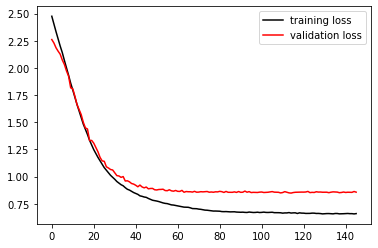

In [27]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot( trainer.train_loss, color = "black", label = "training loss" )
ax.plot( trainer.valid_loss, color = "red", label = "validation loss" )
plt.legend()
plt.show()